In [1]:
import sys
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append("..")
from utils.search_rainfalls import search_rainfalls
from utils.time_series_utils import get_time_series_df, get_compare_by_time_df, check_abnormally_stable_value_station, check_extreme_value_station

sys.path.append("../../")
from common.utils import timestep_csv_names

In [2]:
df = search_rainfalls()
df.head()

,index,date,start_time,peak_time,end_time,duration minutes,max_rainfall
0,42,2019-06-24,16-0,18-40,19-50,230,98.0
1,56,2019-07-12,7-50,8-40,9-50,120,94.0
2,279,2020-08-01,3-40,5-0,7-10,210,88.0
3,338,2020-10-12,6-10,8-10,9-40,210,82.0
4,243,2020-07-27,10-50,12-20,13-40,170,80.0


In [3]:
strong_rainfalls = df.loc[df["max_rainfall"] > 40]
print(len(strong_rainfalls))
strong_rainfalls["date"].value_counts()[:10]

70


2020-10-24    2
2019-06-16    2
2020-08-19    2
2019-04-12    1
2019-05-26    1
2020-05-15    1
2020-04-18    1
2020-05-25    1
2019-07-14    1
2019-06-24    1
Name: date, dtype: int64

In [4]:
import pandas as pd


def convert_time_from_int(int_time: int) -> str:
    str_time = str(int_time)
    return str_time[:-2] + ":" + str_time[-2:]


def reset_time_from_str(x: str, str_time_series: list) -> str:
    center_idx = len(str_time_series) // 2
    time_idx = str_time_series.index(x)
    # if time_idx > center_idx:
    #     time = f"t+{10 * (time_idx - center_idx)}"
    # elif time_idx < center_idx:
    #     time = f"t-{10 * (center_idx - time_idx)}"
    # else:
    #     time = 0
    return 10 * (time_idx - center_idx)

_timestep_csv_names = timestep_csv_names(delta=10)
target_data = {}
for idx in strong_rainfalls.index:
    date = strong_rainfalls.loc[idx, "date"]
    peak_time = strong_rainfalls.loc[idx, "peak_time"]
    peak_time_idx = _timestep_csv_names.index(f"{peak_time}.csv")
    # 2 hours before and after of peak_time
    start_idx, end_idx = peak_time_idx - 18, peak_time_idx + 18
    if start_idx < 0 or end_idx > len(_timestep_csv_names) - 1:
        print(f"{date} is skipped. (start: {start_idx}, end: {end_idx})")
        continue
    target_data[date] = {"start_time": _timestep_csv_names[start_idx].replace(".csv", ""), "end_time": _timestep_csv_names[end_idx].replace(".csv", "")}


data_df = pd.DataFrame(columns=["Time", "ParamName", "Value", "Station_Name", "date"])
for date in target_data.keys():
    year, month, day = date.split("-")
    time_series_df = get_time_series_df(
        one_day_data_dir_path="../../../data/one_day_data",
        year=year,
        month=month,
        date=day,
        start_time=target_data[date]["start_time"],
        end_time=target_data[date]["end_time"],
    )
    compare_df = get_compare_by_time_df(time_series_df, set_zero_start=False, scaling_method="none")
    # Reset Time
    unique_times = compare_df["Time"].unique()
    sorted_unique_times = sorted([int(t.replace(":", "")) for t in unique_times])
    sorted_unique_times = [convert_time_from_int(t) for t in sorted_unique_times]
    compare_df["Time"] = compare_df["Time"].apply(reset_time_from_str, args=(sorted_unique_times,))
    # Add date col for hue
    compare_df["date"] = date
    data_df = pd.concat([data_df, compare_df], axis=0, ignore_index=True)

2020-07-12 is skipped. (start: 114, end: 150)
2019-08-24 is skipped. (start: -10, end: 26)
2019-08-01 is skipped. (start: 119, end: 155)


In [5]:
target_poteka_params = ["hour-rain", "AT1", "RH1", "WS1", "U-Wind", "V-Wind"]
target_params = ["Hourly rainfall", "Temperature", "Relative Humidity", "Wind Speed", "U-Wind", "V-Wind"]
data_df = data_df.replace(target_poteka_params, target_params)
data_df.head()

,Time,ParamName,Value,Station_Name,date
0,-180,Hourly rainfall,0.0,Vlz-Bagbaguin_00174731,2019-06-24
1,-180,Hourly rainfall,3.5,Vlz-Punturin_00174725,2019-06-24
2,-180,Hourly rainfall,0.0,DOST_00174730,2019-06-24
3,-180,Hourly rainfall,0.0,MM-Balut_00174728,2019-06-24
4,-180,Hourly rainfall,0.0,CAAP_00174729,2019-06-24


In [6]:
import json

with open('../meta_data/observation_point.json', 'r') as f:
    obpoint_data = json.load(f)

obpoints_df = pd.DataFrame({
    "Station_Name": [n for n in obpoint_data.keys()],
    "longitude": [v["longitude"] for v in obpoint_data.values()],
    "latitude": [v["latitude"] for v in obpoint_data.values()]
})

columns = ["date", "Time", "max_rainfall", "station_name", "lon", "lat"]
res_df = pd.DataFrame(columns=columns)
dates_rainfall_df = data_df.loc[data_df["ParamName"] == "Hourly rainfall"].groupby(by=["date", "Time"])
for name, df in dates_rainfall_df:
    obpoint_with_max_rainfall = df.loc[df["ParamName"] == df["ParamName"].max()].sort_values(by=["Value"], ascending=False)
    if obpoint_with_max_rainfall["Value"].sum() == 0:
        continue;
    station_name = obpoint_with_max_rainfall["Station_Name"].iloc[0]
    obpoint_lonlat = obpoints_df.loc[obpoints_df["Station_Name"] == station_name]
    # print(obpoint_lonlat, name, station_name)
    # print(obpoint_with_max_rainfall)|
    res_df = pd.concat([res_df, pd.DataFrame.from_records(
        [(name[0], name[1], obpoint_with_max_rainfall["Value"].iloc[0], station_name, obpoint_lonlat["longitude"].iloc[0], obpoint_lonlat["latitude"].iloc[0])],
        columns=columns,
    )])

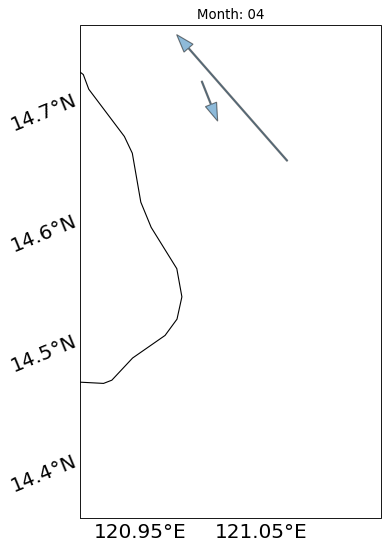

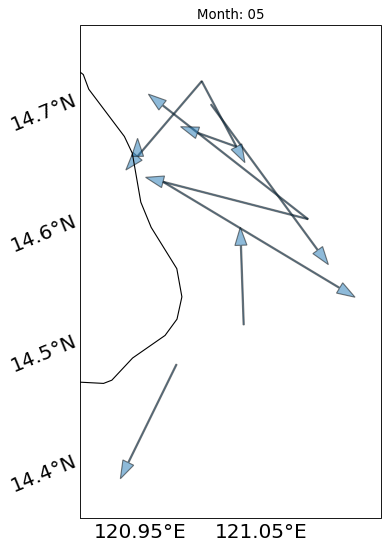

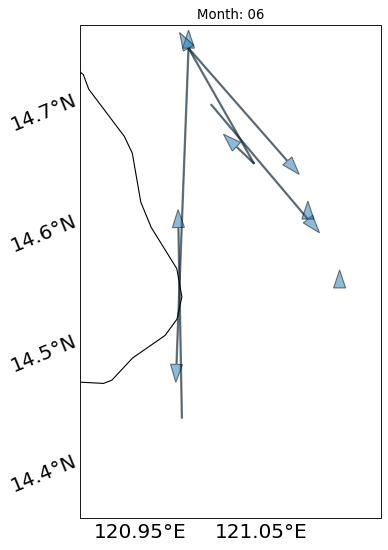

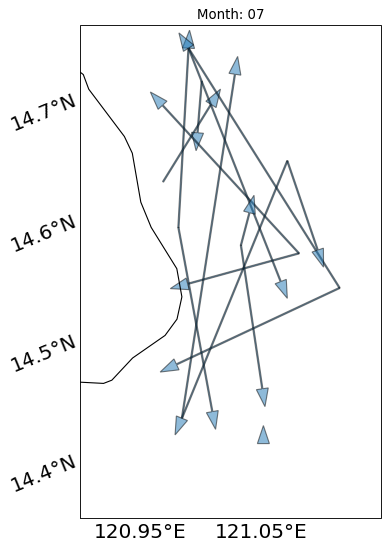

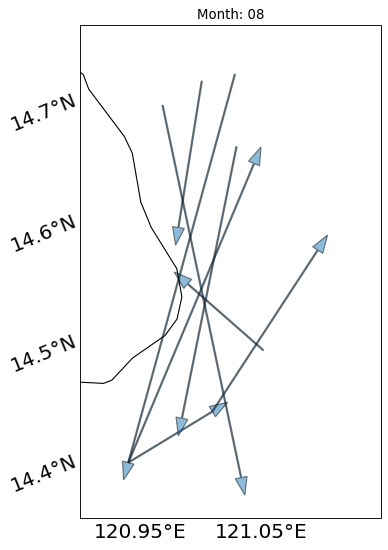

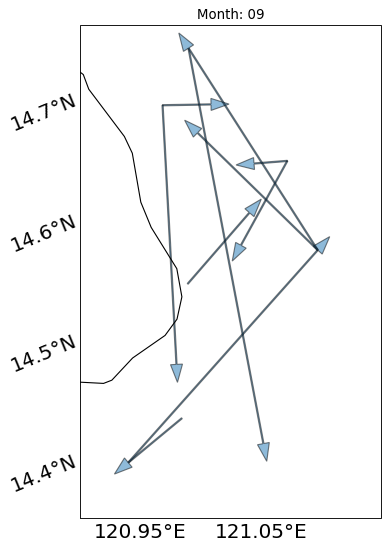

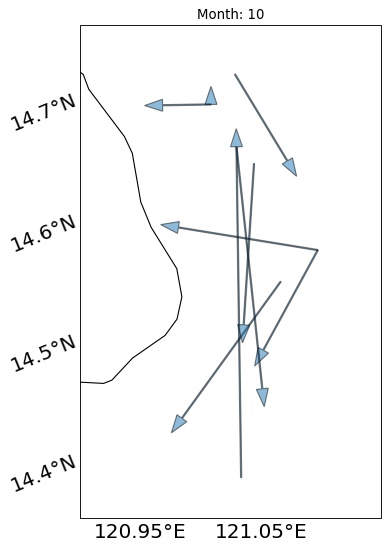

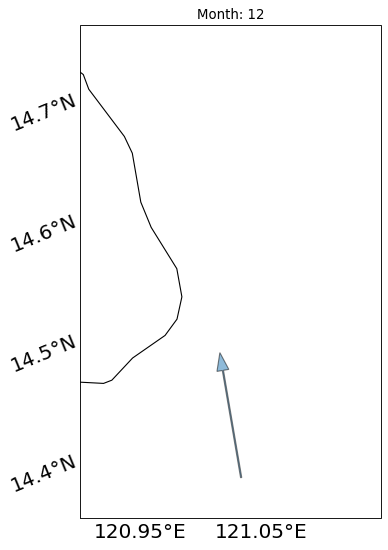

In [58]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature


class TargetManilaErea:
    MAX_LONGITUDE = 121.150
    MIN_LONGITUDE = 120.90

    MAX_LATITUDE = 14.760
    MIN_LATITUDE = 14.350

def generate_geo_plot():
    fig = plt.figure(figsize=(7, 8), dpi=80)
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    ax.set_extent(
        [
            TargetManilaErea.MIN_LONGITUDE,
            TargetManilaErea.MAX_LONGITUDE,
            TargetManilaErea.MIN_LATITUDE,
            TargetManilaErea.MAX_LATITUDE,
        ],
        crs=ccrs.PlateCarree(),
    )
    gl = ax.gridlines(draw_labels=True, alpha=0)
    gl.right_labels = False
    gl.top_labels = False
    gl.ylabel_style = {'rotation': 45, 'fontsize': 18}
    gl.xlabel_style = {'fontsize': 18}
    return ax

res_df["month"] = res_df["date"].apply(lambda x: x.split("-")[1])
for (month, month_df) in res_df.groupby(by=["month"]):
    ax = generate_geo_plot()
    for date, df in month_df.groupby(by=["date"]):
        df = df.sort_values(by=["Time"])
        df['dx'] = df["lon"].diff()
        df['dy'] = df["lat"].diff()
        df['drain'] = df["max_rainfall"].diff()

        # get start
        start_lon, start_lat = df["lon"].iloc[0], df["lat"].iloc[0]
        peak_lon, peak_lat = df.loc[df.Time == 0][["lon", "lat"]].iloc[0]
        dx, dy = peak_lon - start_lon, peak_lat - start_lat
        ax.arrow(start_lon, start_lat, dx, dy, head_width=0.01, alpha=0.5)
        # for idx in range(len(df)-1):
        #     time, dx, dy, lon, lat = df["Time"].iloc[idx], df['dx'].iloc[idx+1], df["dy"].iloc[idx+1], df['lon'].iloc[idx], df['lat'].iloc[idx]
        #     if time == 10:
        #         # Stop at the peak
        #         break
        #     if idx == 0:
        #         # Plot start
        #         ax.plot(lon, lat, marker='s', markersize=10, color='green', alpha=0.7)
        #     if time == 0:
        #         # Plot peak
        #         ax.plot(lon, lat, marker='*', markersize=10, color='red', alpha=0.7)
        #     if dx == 0 and dy == 0:
        #         continue
        #     ax.arrow(df['lon'].iloc[idx], df["lat"].iloc[idx], dx, dy, head_width=0.01, alpha=0.5)

    ax.add_feature(cfeature.COASTLINE)
    ax.set_title(f"Month: {month}")
    plt.show()
    plt.close()

<AxesSubplot:ylabel='Count'>

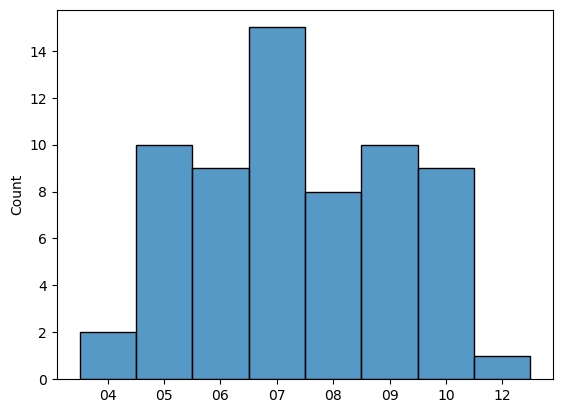

In [47]:
monthes = np.array(list(map(lambda x: x.split("-")[1], res_df["date"].unique())))
sns.histplot(monthes)

In [44]:
res_df["date"].unique()

array(['2019-04-12', '2019-05-08', '2019-05-21', '2019-05-22',
       '2019-05-26', '2019-06-09', '2019-06-16', '2019-06-23',
       '2019-06-24', '2019-06-25', '2019-06-28', '2019-07-08',
       '2019-07-12', '2019-07-14', '2019-07-16', '2019-07-19',
       '2019-07-25', '2019-07-28', '2019-08-02', '2019-09-11',
       '2019-09-14', '2019-09-19', '2019-10-02', '2019-10-04',
       '2019-10-11', '2019-10-12', '2019-10-22', '2019-12-25',
       '2020-04-18', '2020-05-06', '2020-05-09', '2020-05-15',
       '2020-05-25', '2020-05-28', '2020-05-29', '2020-06-09',
       '2020-06-11', '2020-06-23', '2020-07-04', '2020-07-05',
       '2020-07-11', '2020-07-21', '2020-07-25', '2020-07-26',
       '2020-07-27', '2020-07-29', '2020-08-01', '2020-08-06',
       '2020-08-07', '2020-08-11', '2020-08-16', '2020-08-19',
       '2020-08-20', '2020-09-06', '2020-09-07', '2020-09-14',
       '2020-09-22', '2020-09-23', '2020-09-24', '2020-09-29',
       '2020-10-03', '2020-10-04', '2020-10-12', '2020-